<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_NLP/blob/main/Tagging_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages and Modules Importation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('treebank')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, Dense, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

Mounted at /content/drive


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


# **Tagging Task, 태깅 작업**

## **POS(Part-Of-Speech) Tagging with Bi-LSTM, 양방향 LSTM을 통한 품사 태깅**  


---

- **다대다 문제**이므로 **LSTM의 `return_sequences=True`**로 설정, **양방향 사용**을 위해 **`Bidirectional()` 사용**
- target label에 대해 One-Hot Encoding 이후 Loss function으로 `categorical_crossentropy` 사용이 아닌, **원본 target label을 사용하되 Loss function으로 `sparse_categorical_crossentropy` 사용**
- data의 padding으로 인해 0의 값이 많아질 때에는 **`Embedding()`의 argument로 `mask_zero=True`를 설정하면 0의 값은 연산에서 제외**
- 출력층에 **`TimeDistributed()`를 사용해 LSTM의 모든 time step에서 출력층을 사용**

품사 태깅된 문장 갯수 = 3914
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]

Maximum Length = 271
Average Length = 25.722024


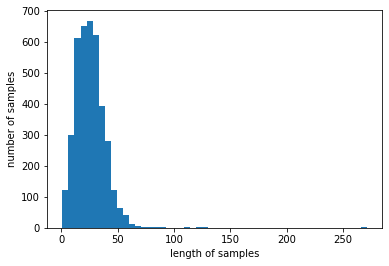


Vocabulary Size = 11388
Tagging Set Size = 47

Train Data Size = (3131, 150)
Train Label Size = (3131, 150)
Test Data Size = (783, 150)
Test Label Size = (783, 150)


In [ ]:
tagged_sents = nltk.corpus.treebank.tagged_sents()      # 토큰화에 품사 태깅이 된 데이터 불러오기
print("품사 태깅된 문장 갯수 =", len(tagged_sents))
print(tagged_sents[0])
print()

sents, pos_tags = [], []
for tagged_sent in tagged_sents:
    sent, tag_info = zip(*tagged_sent)      # 각 샘플에서 단어는 sent에, 품사 정보는 tag_info에 저장
    sents.append(list(sent))
    pos_tags.append(list(tag_info))

print('Maximum Length = %d' % max(len(line) for line in sents))         # max_len으로의 padding을 위한 데이터의 길이 분포 확인 
print('Average Length = %f' % (sum(map(len, sents)) / len(sents)))
plt.hist([len(sent) for sent in sents], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
print()

def tokenize(samples):                                  # Integer Encoding 수행
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

src_tokenizer = tokenize(sents)
tar_tokenizer = tokenize(pos_tags)
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print("Vocabulary Size =", vocab_size)
print("Tagging Set Size =", tag_size)
print()

X_train = src_tokenizer.texts_to_sequences(sents)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

max_len = 150          # padding 작업
X_train = pad_sequences(X_train, padding="post", maxlen=max_len)
y_train = pad_sequences(y_train, padding="post", maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)
print('Train Data Size = {}'.format(X_train.shape))
print('Train Label Size = {}'.format(y_train.shape))
print('Test Data Size = {}'.format(X_test.shape))
print('Test Label Size = {}'.format(y_test.shape))

In [ ]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation="softmax")))

model.compile(optimizer=Adam(0.01), loss="sparse_categorical_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, epochs=7, batch_size=128, validation_data=(X_test, y_test))
print()

print("Test Accuracy = %.4f" % (model.evaluate(X_test, y_test)[1]))
print()

index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

idx = 10                                                                        # 예측하고 싶은 데이터의 index 설정
y_pred = model.predict(np.array([X_test[idx]]))                                 # 예측한 y_pred return
print(f"Shape of y_pred = {y_pred.shape}")
print()

y_pred = np.argmax(y_pred, axis=-1)                                             # One-Hot Encoding을 Integer Encoding으로 변환, armax의 axis=-1이면 뒤에서부터 순서대로 최댓값의 index 반환
print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")
for word, tag, pred in zip(X_test[idx], y_test[idx], y_pred[0]):
    if word != 0:       # 0번 PAD(padding) token은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

Epoch 1/7
25/25 [==============================] - 55s 2s/step - loss: 0.4161 - acc: 0.3853 - val_loss: 0.1466 - val_acc: 0.8077
Epoch 2/7
25/25 [==============================] - 44s 2s/step - loss: 0.0599 - acc: 0.9143 - val_loss: 0.0420 - val_acc: 0.9294
Epoch 3/7
25/25 [==============================] - 49s 2s/step - loss: 0.0150 - acc: 0.9739 - val_loss: 0.0388 - val_acc: 0.9336
Epoch 4/7
25/25 [==============================] - 47s 2s/step - loss: 0.0086 - acc: 0.9844 - val_loss: 0.0396 - val_acc: 0.9365
Epoch 5/7
25/25 [==============================] - 39s 2s/step - loss: 0.0056 - acc: 0.9906 - val_loss: 0.0409 - val_acc: 0.9360
Epoch 6/7
25/25 [==============================] - 39s 2s/step - loss: 0.0040 - acc: 0.9940 - val_loss: 0.0430 - val_acc: 0.9350
Epoch 7/7
25/25 [==============================] - 40s 2s/step - loss: 0.0027 - acc: 0.9964 - val_loss: 0.0430 - val_acc: 0.9353

25/25 [==============================] - 5s 200ms/step - loss: 0.0430 - acc: 0.9353
Test Accurac

## **BIO(Begin-Inside-Outside) Expression of NER(Named Unity Recognition), 개체명 인식의 BIO 표현**  


---

#### **CONLL2003 : NER 위한 전통적인 영어 데이터셋**
*Link in Bio : https://paperswithcode.com/dataset/conll-2003*  
*Link in Bio : https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html*

```
EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER
```

- **Data 형식 : [Word] [POS] [Chunk Tagging] [NER]**  
ex) 예를 들어서 EU 옆에 붙어있는 **NNP는 고유 명사 단수형**, rejects 옆에 있는 **VBZ는 3인칭 단수 동사 현재형**  
- **Tagging의 종류 : LOC는 location, ORG는 organization, PER은 person, MISC는 miscellaneous**  
- 개체명의 시작 부분이면서 Organization을 의미하는 **German에는 B-ORG라는 개체명 tagging**을 붙임. But German 그 자체로 개체명 하나이기 때문에 거기서 개체명 인식은 종료되면서 뒤에 I가 별도로 붙는 단어가 나오지 않음. German 뒤에 나오는 **call은 개체명이 아니기 때문에 O이 tagging**
- 9번째 line에서 문장이 끝나고 한줄 공백을 삽입한 후, 11번째 line에 다음 문장이 시작됨
- Peter는 개체명이 시작되면서 person에 해당되기 때문에 B-PER이라는 개체명 tagging이 붙음. 그리고 아직 개체명에 대한 인식은 끝나지 않았기 때문에 뒤에 붙는 Blackburn에서는 I가 나오면서 **I-PER이 개체명 tagging**으로 붙게 됨. 즉, **Peter Blackburn이 person에 속하는 하나의 개체명**

Total Sample Size = 14041

Maximum Length : 113
Average Length : 14.501887


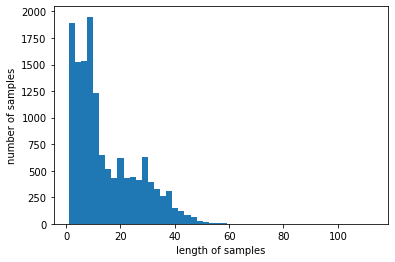

In [ ]:
file = open(os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "CAU AI Class", "data", "train.txt"), "r")

tagged_sents = []               # 단어와 개체명 tag의 pair로 이루어진 sent들의 list
sent = []                       # 공백으로 문장 간 구분

for line in file:
    if len(line) == 0 or line.startswith("-DOCSTART") or line[0] == "\n":
        if len(sent) > 0:
            tagged_sents.append(sent)           # 공백 line이 하나의 sent가 끝난 이후에 나왔다면, 지금까지 만들어진 sent를 tagged_sent에 추가
            sent = []                           # sent 리스트는 초기화
        continue
    
    splits = line.split(" ")                        # 공백 기준 split
    splits[-1] = re.sub(r"\n", "", splits[-1])      # 줄바꿈 문자 제거
    word = splits[0].lower()                        # 소문자화
    sent.append([word, splits[-1]])                 # 단어와 개체명 tag만 기록

print("Total Sample Size =", len(tagged_sents))
print()

sents, ner_tags = [], []
for tagged_sent in tagged_sents:
    sent, tag_info = zip(*tagged_sent)
    sents.append(list(sent))
    ner_tags.append(list(tag_info))

print('Maximum Length : %d' % max(len(l) for l in sents))               # 문장 sample의 길이 분포 확인
print('Average Length : %f' % (sum(map(len, sents)) / len(sents)))
plt.hist([len(s) for s in sents], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_words = 4000

src_tokenizer = Tokenizer(num_words=max_words, oov_token="OOV")         # for 문장 data
src_tokenizer.fit_on_texts(sents)
tar_tokenizer = Tokenizer()                                             # for Tagging data
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('Vocabulary Size = {}'.format(vocab_size))
print('Tagging Set Size = {}'.format(tag_size))
print()

X_train = src_tokenizer.texts_to_sequences(sents)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

decoded = []
for idx in X_train[0]:                                                          # OOV로 대체된 것들에 대해 sample data 디코딩하여 확인
    decoded.append(index_to_word[idx])
print('Original Sentence = {}'.format(sents[0]))
print('OOV Sentence = {}'.format(decoded))
print()

max_len = 70                                                                    # padding 작업 수행
X_train = pad_sequences(X_train, padding="post", maxlen=max_len)
y_train = pad_sequences(y_train, padding="post", maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)
print('Train Data Size : {}'.format(X_train.shape))
print('Train Label Size : {}'.format(y_train.shape))
print('Test Data Size : {}'.format(X_test.shape))
print('Test Label Size : {}'.format(y_test.shape))

Vocabulary Size = 4000
Tagging Set Size = 10

Original Sentence = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
OOV Sentence = ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']

Train Data Size : (11232, 70)
Train Label Size : (11232, 70, 10)
Test Data Size : (2809, 70)
Test Label Size : (2809, 70, 10)


In [ ]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation="softmax")))
model.summary()
print()

model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, epochs=8, batch_size=128, validation_data=(X_test, y_test))
print("Test Accuracy = %.4f" % (model.evaluate(X_test, y_test)[1]))
print()

idx = 10                                                                        # 확인하고 싶은 테스트용 sample index
y_pred = model.predict(np.array([X_test[idx]]))                                 # 입력한 테스트용 샘플에 대해서 y_pred return
y_pred = np.argmax(y_pred, axis=-1)                                             # 확률값 벡터를 Integer Encoding으로 변경
true = np.argmax(y_test[idx], -1)                                               # One-Hot Vector를 Integer Encoding으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[idx], true, y_pred[0]):
    if word != 0:           # PAD(padding) token값은 제외
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 128)           512000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 70, 256)          263168    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 70, 10)           2570      
 tributed)                                                       
                                                                 
Total params: 777,738
Trainable params: 777,738
Non-trainable params: 0
_________________________________________________________________

Epoch 1/8
88/88 [==============================] - 68s 681ms/step - loss: 0.1994 - acc: 0.8237 - val_loss: 0.1313 - val_acc: 0.8333
Epoch 2/8
88/88 [==============================